### Biel González Garriga NIU:1551813

# Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from pandas_profiling import ProfileReport
from myLibrary.myFunctions import *
from myLibrary.DatasetProcessing import *
import time

In [2]:
#importing libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import time
import matplotlib.pyplot as plt

import sklearn.metrics as metrics

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict #prediction

import warnings
warnings.filterwarnings('ignore')

In [3]:
display(HTML("<style>.container {width:99% !important; }</style>"))

## Carrega i preparació del dataframe

In [4]:
df = pd.read_csv('lol_ranked_games.csv', header=0, delimiter=',')
print("================================\n",
      "\tDataframe loaded\n",
      "================================\n")

 	Dataframe loaded



In [5]:
finishedGame_df=preProcessing(df,False)[0]

 	Basic information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242572 entries, 0 to 242571
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameId                   242572 non-null  int64  
 1   gameDuration             242572 non-null  int64  
 2   hasWon                   242572 non-null  int64  
 3   frame                    242572 non-null  int64  
 4   goldDiff                 242572 non-null  int64  
 5   expDiff                  242572 non-null  int64  
 6   champLevelDiff           242572 non-null  float64
 7   isFirstTower             242572 non-null  int64  
 8   isFirstBlood             242572 non-null  int64  
 9   killedFireDrake          242572 non-null  int64  
 10  killedWaterDrake         242572 non-null  int64  
 11  killedAirDrake           242572 non-null  int64  
 12  killedEarthDrake         242572 non-null  int64  
 13  killedElderDrake         242572 non-nu

In [6]:
train,test=train_test_split(finishedGame_df,test_size=0.2,random_state=3)
X_train=train.drop(["gameId","frame","hasWon"],axis=1)
Y_train=train.pop("hasWon")
X_test=test.drop(["gameId","frame","hasWon"],axis=1)
Y_test=test.pop("hasWon")

## Observacio de les features

#### RFECV

In [7]:
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=2),
    step=1,
    cv=StratifiedKFold(2),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, Y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 76


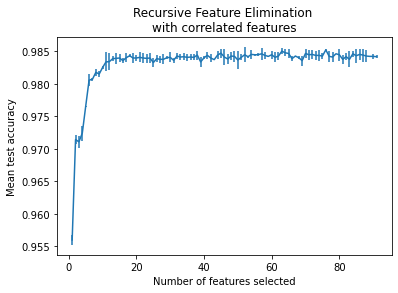

In [8]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

Podem veure del RFECV que ben des de l'inici tenim ja molt bons resultats amb el nombre de features seleccionat i que tot i que aquesta puja el canvi mai es massa significatiu i s'estableix sobre uns 0,985. Podem extreure d'aqui que amb el dataset que tenim no ens hem de preocupar massa per les nostres features ja que obtindrem bons resultats independentment del nombre que fem servir d'aquestes.

#### PCA

In [9]:
pca=PCA()
scaler=StandardScaler()
logistic=LogisticRegression()
pipe=Pipeline(steps=[("scaler",scaler),("pca", pca), ("logistic", logistic)])
param_grid = {
    "pca__n_components": [1, 15, 30, 45, 60],
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(X_train,Y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.986):
{'pca__n_components': 60}


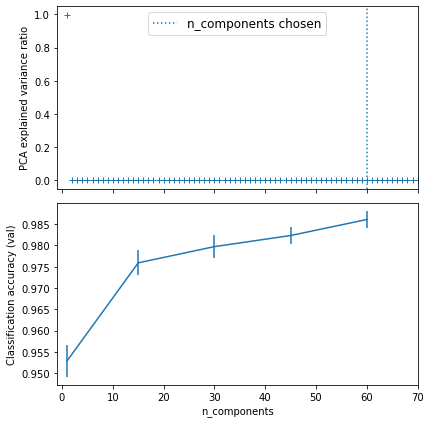

In [10]:
# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()

Amb la PCA veiem de manera similar al RFECV que exceptuant a un punt a l'inici amb qualsevol nombre de components el nostre model te una una molt bona accuracy de components. Tot i així veiem que al gràfic de la variancia explicada segons el nombre de components triat. S'observa que amb una component ja s'explica la gran majoria per no dir tot el model, per tant des de l'inici ja tenim la majoria de l'explicabilitat del model donada.

## Execució de models

In [11]:
models={}

### Regressió Logistica

#### Classificació d'una sola feature

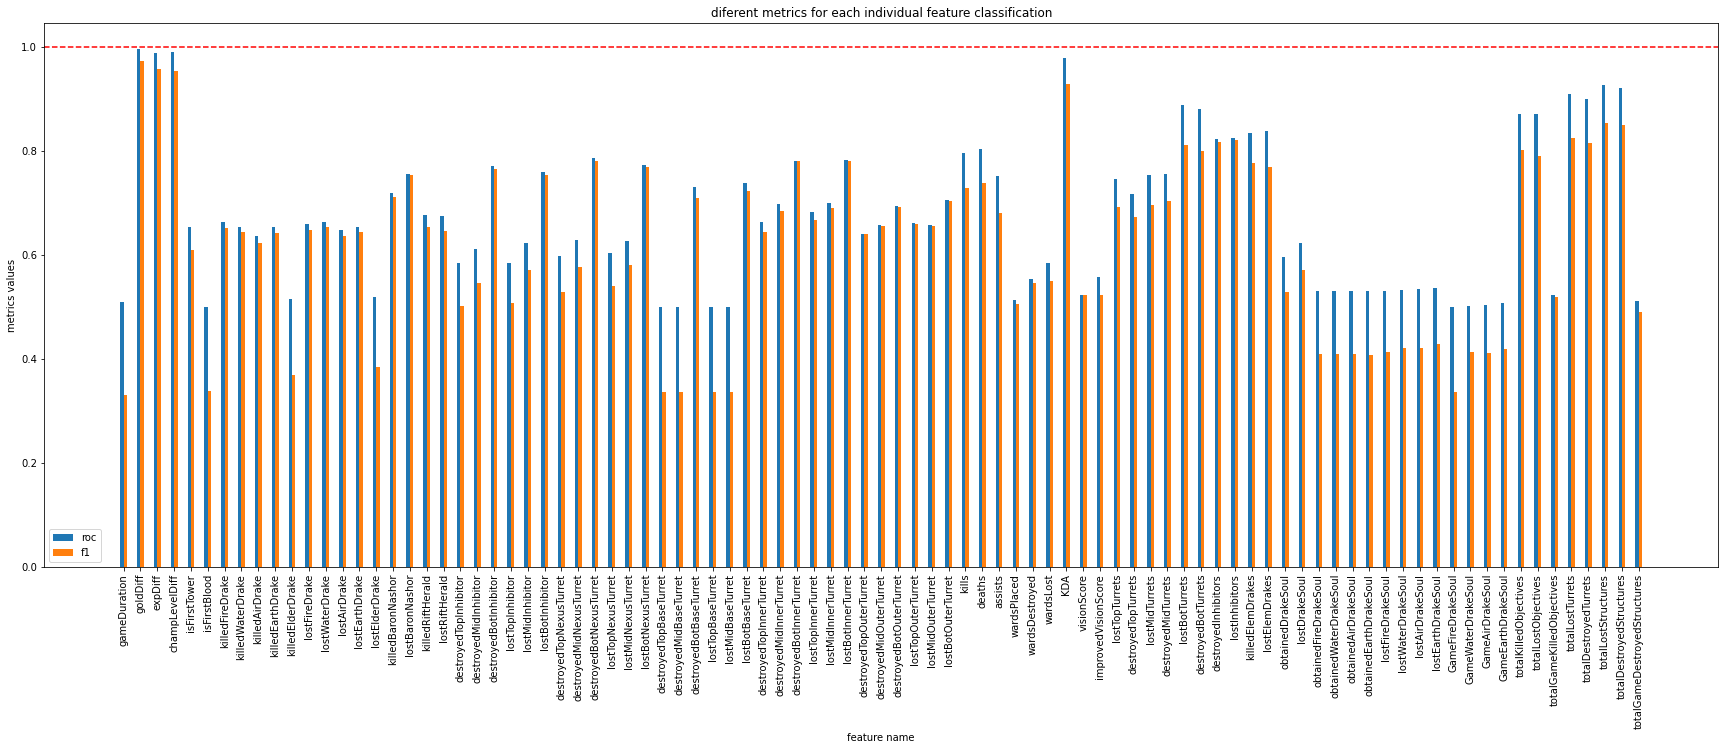

In [12]:
oneFeatureClassification(X_train,
                         Y_train,
                         X_test,
                         Y_test,
                         LogisticRegression(),
                        )

Amb només una feature i la logística observem que tot i haver features que ens donen mals resultats hi ha d'altres amb les que obtenim uns resultats molt bons com ho son `goldDiff`, `expDiff`, `champLevelDiff` i `KDA`. Això es positiu ja que amb el minim esforç que requereix una logística amb només una feature podem fer prediccions en poc temps sense sacrificar resultats. Tot i així només amb algunes de les features com s'ha dit abans, no ens serveix qualsevol.

#### Classificació amb tot el dataset

Model: LogisticRegression
Training time is:  0.1794276237487793 s
Base sklearn score is:  0.9747140276941602
ROC score is:  0.9971053437082145
F1 score is: 0.9755167569737107
Accuracy score is: 0.9755167569737107
Precision score is: 0.9755167569737107


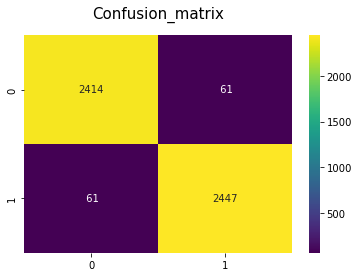

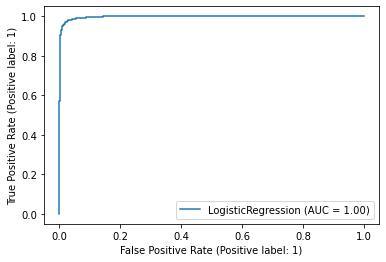

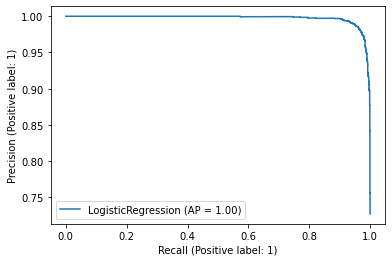

In [13]:
results=fullModelClassification(LogisticRegression(),X_train,Y_train,X_test,Y_test,True)
models[results[0]]=results[1]

En un model amb totes les features obtenim també uns resultats més que notables a la nostra classificació. El temps d'entrenament es baix i les diferents mètriques ens donen molt bons resultats a l'hora de mirar amb el test, per tant podem observar que molt probablement no hi hagi overfitting.

#### Feature importance

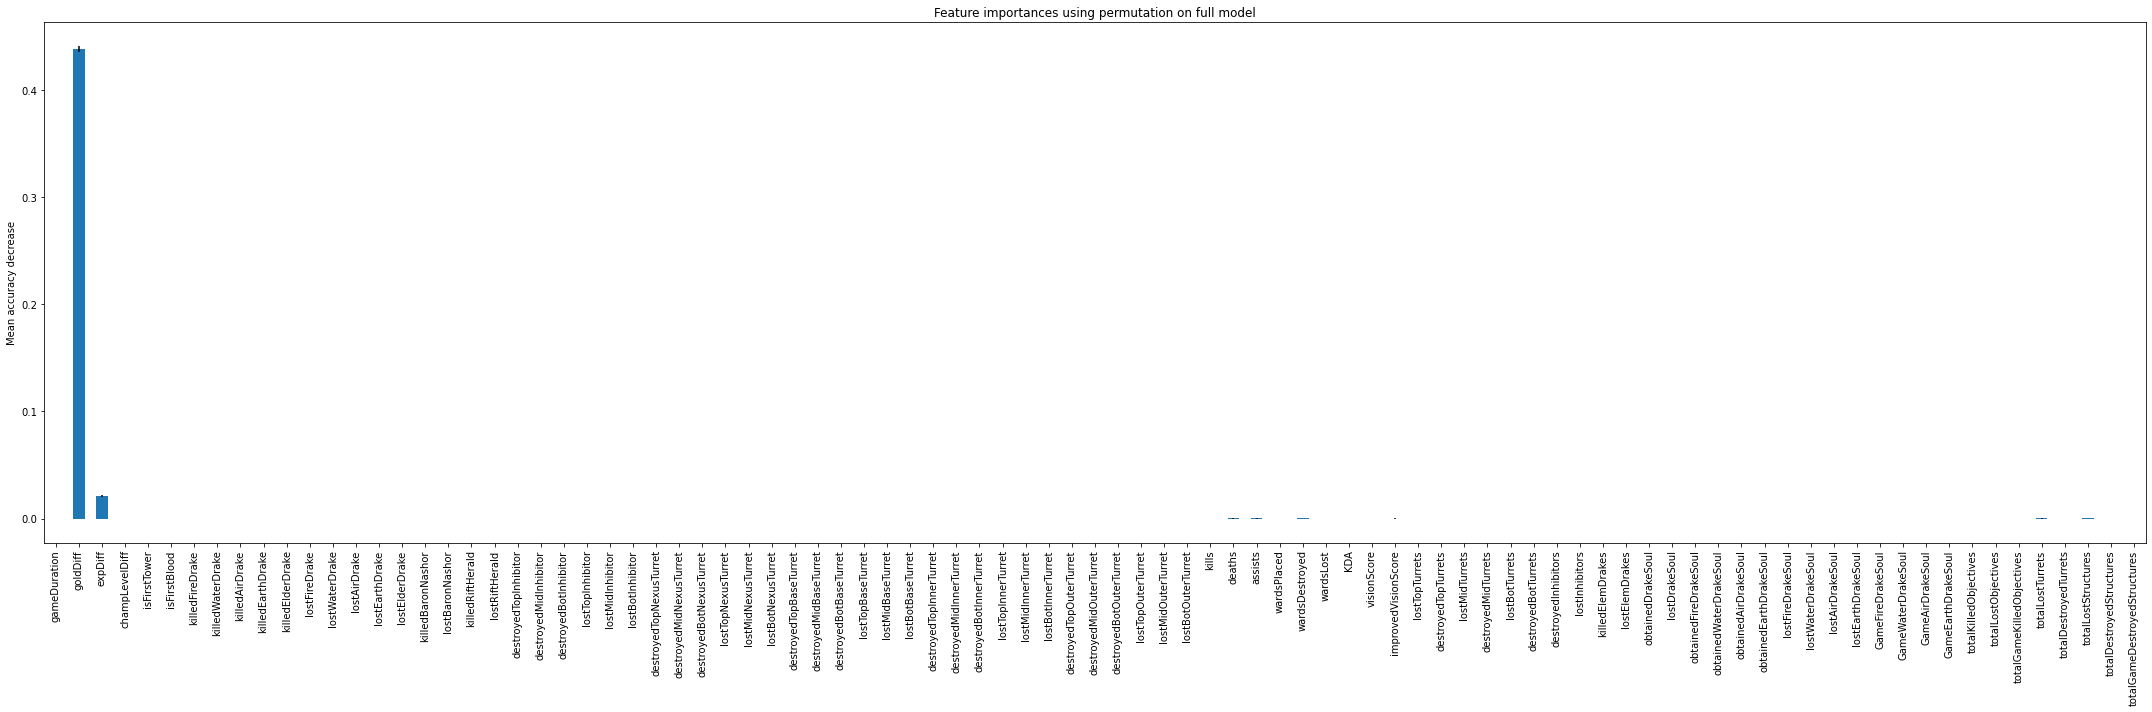

In [14]:
featureImportance(X_train,Y_train,
                  models['LogisticRegression'][0],
                  X_train.columns,
                  (30,10),
                 )

La regressió logística dona moltissima importancia al atribut `goldDiff` i despres a `expDiff`, però molt menys. Coincideix bastant amb els resultats que haviem trobat fent la classificació amb una sola feature ja que la que ens donava millors resultats era també `goldDiff`.

### Perceptron

#### Classificació d'una sola feature

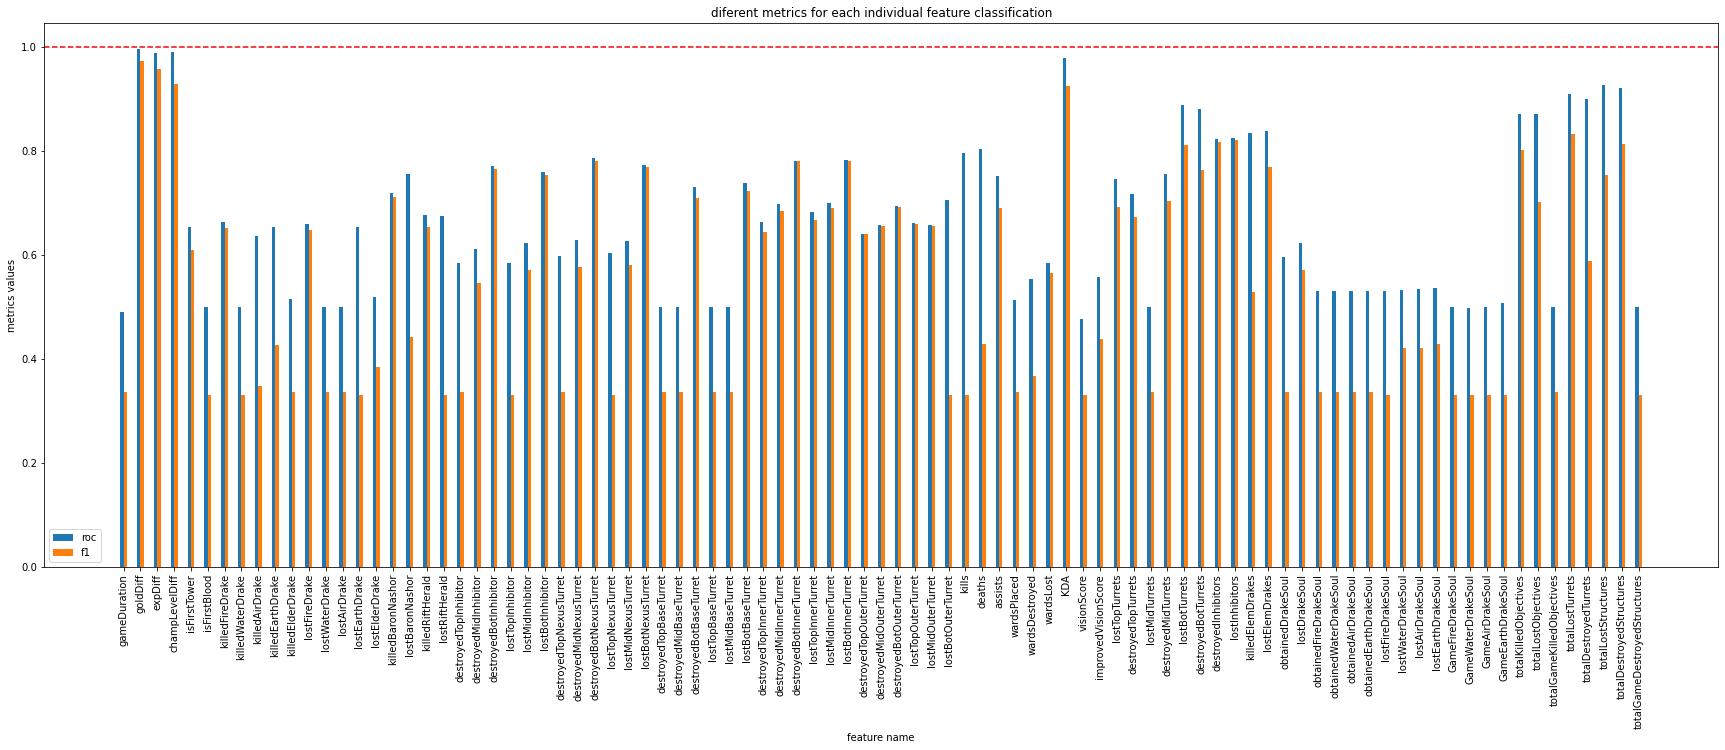

In [15]:
oneFeatureClassification(X_train,
                         Y_train,
                         X_test,
                         Y_test,
                         Perceptron(),
                        )

Observem uns resultats molt semblants als que ens ha donat amb la logística. Els millors tornen a ser `goldDiff`, `expDiff`, `champLevelDiff` i `KDA`

#### Classificació amb tot el dataset

Model: Perceptron
Training time is:  0.2362065315246582 s
Base sklearn score is:  0.8741721854304636
ROC score is:  0.9568456494772283
F1 score is: 0.8677517999196604
Accuracy score is: 0.8677503511940599
Precision score is: 0.8677734481276087


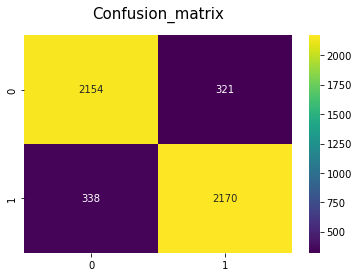

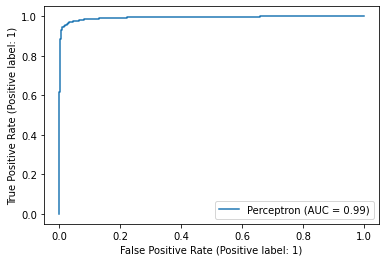

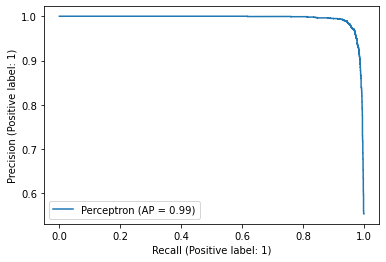

In [16]:
results=fullModelClassification(Perceptron(),X_train,Y_train,X_test,Y_test,True)
models[results[0]]=results[1]

El perceptrón triga més que la logística i els resultats son una mica pitjors quan mirem les métriques. Igualment ens dona uns resultats més que acceptables amb poc temps invertit.

#### Feature importance

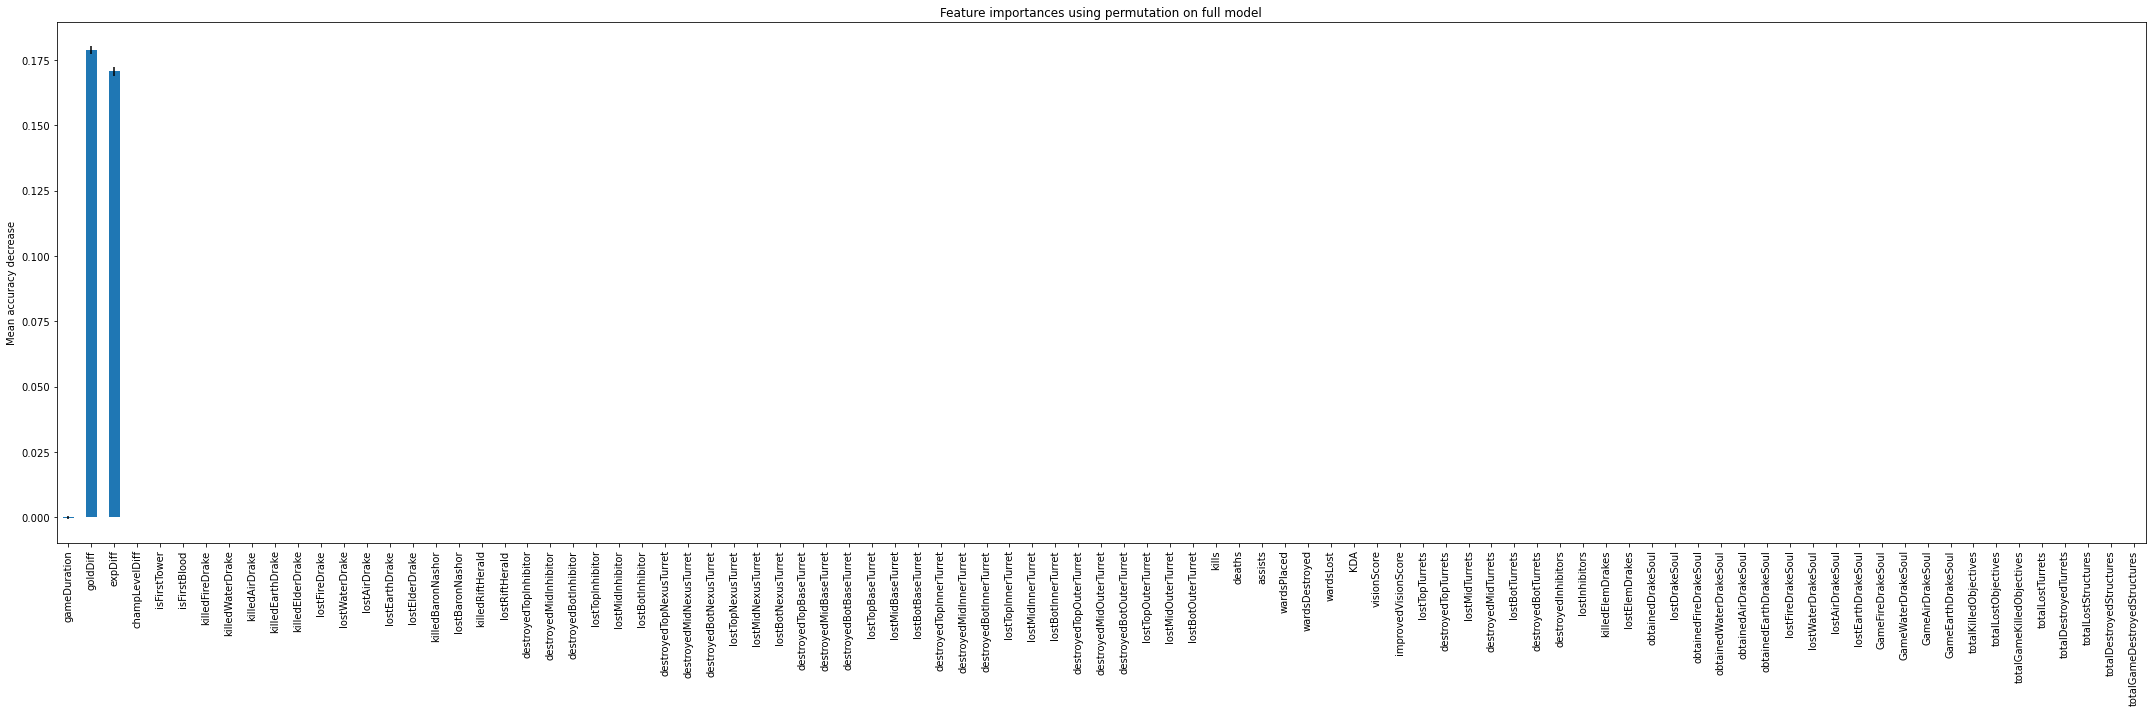

In [17]:
featureImportance(X_train,Y_train,
                  models['Perceptron'][0],
                  X_train.columns,
                  (30,10),
                 )

Aquí sí que observem canvis notables. La importancia dels diferents atributs canvia, amb el perceptron la `goldDiff` es molt menys rellevant que amb la logística i la `expDiff`guanya més rellevancia per al nostre model.

### Ada Boosting Classifier

#### Classificació d'una sola feature

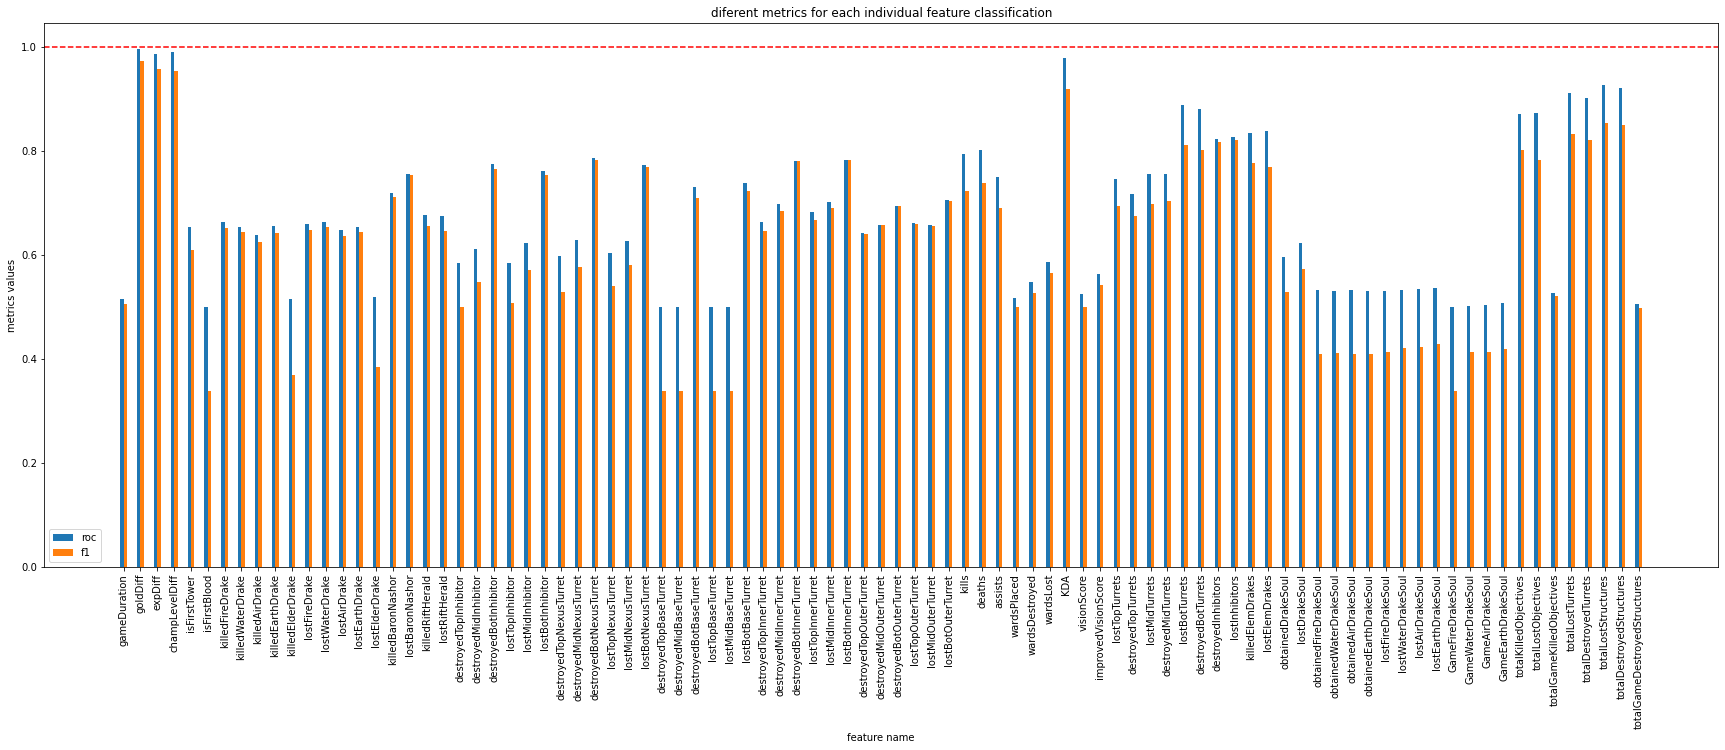

In [18]:
oneFeatureClassification(X_train,
                         Y_train,
                         X_test,
                         Y_test,
                         AdaBoostClassifier(),
                        )

Respecte als dos models anteriors veiem que en mitjana les mètriques de tots els atributs que abans eren molt baixes milloren mentre que les quatre que abans eren ja molt bones es mantenen. 

#### Classificació amb tot el dataset

Model: AdaBoostClassifier
Training time is:  6.164045572280884 s
Base sklearn score is:  0.983744732089103
ROC score is:  0.9972155365456801
F1 score is: 0.9859522376078668
Accuracy score is: 0.9859522376078668
Precision score is: 0.9859522376078668


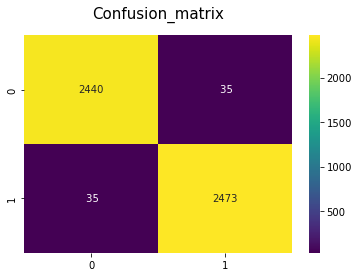

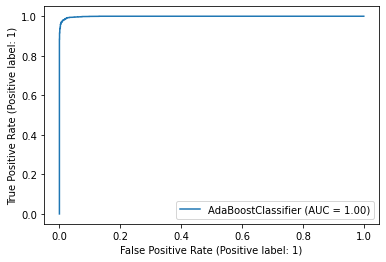

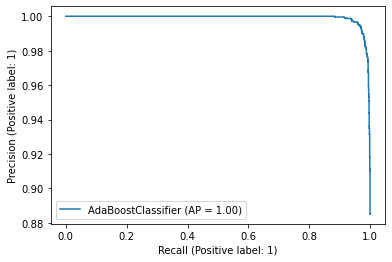

In [19]:
results=fullModelClassification(AdaBoostClassifier(),X_train,Y_train,X_test,Y_test,True)
models[results[0]]=results[1]

Tot i que aquest model triga més que els anteriors els resultats son una miqueta millors que els altres dos com podem observar amb les mètriques.

#### Feature importance

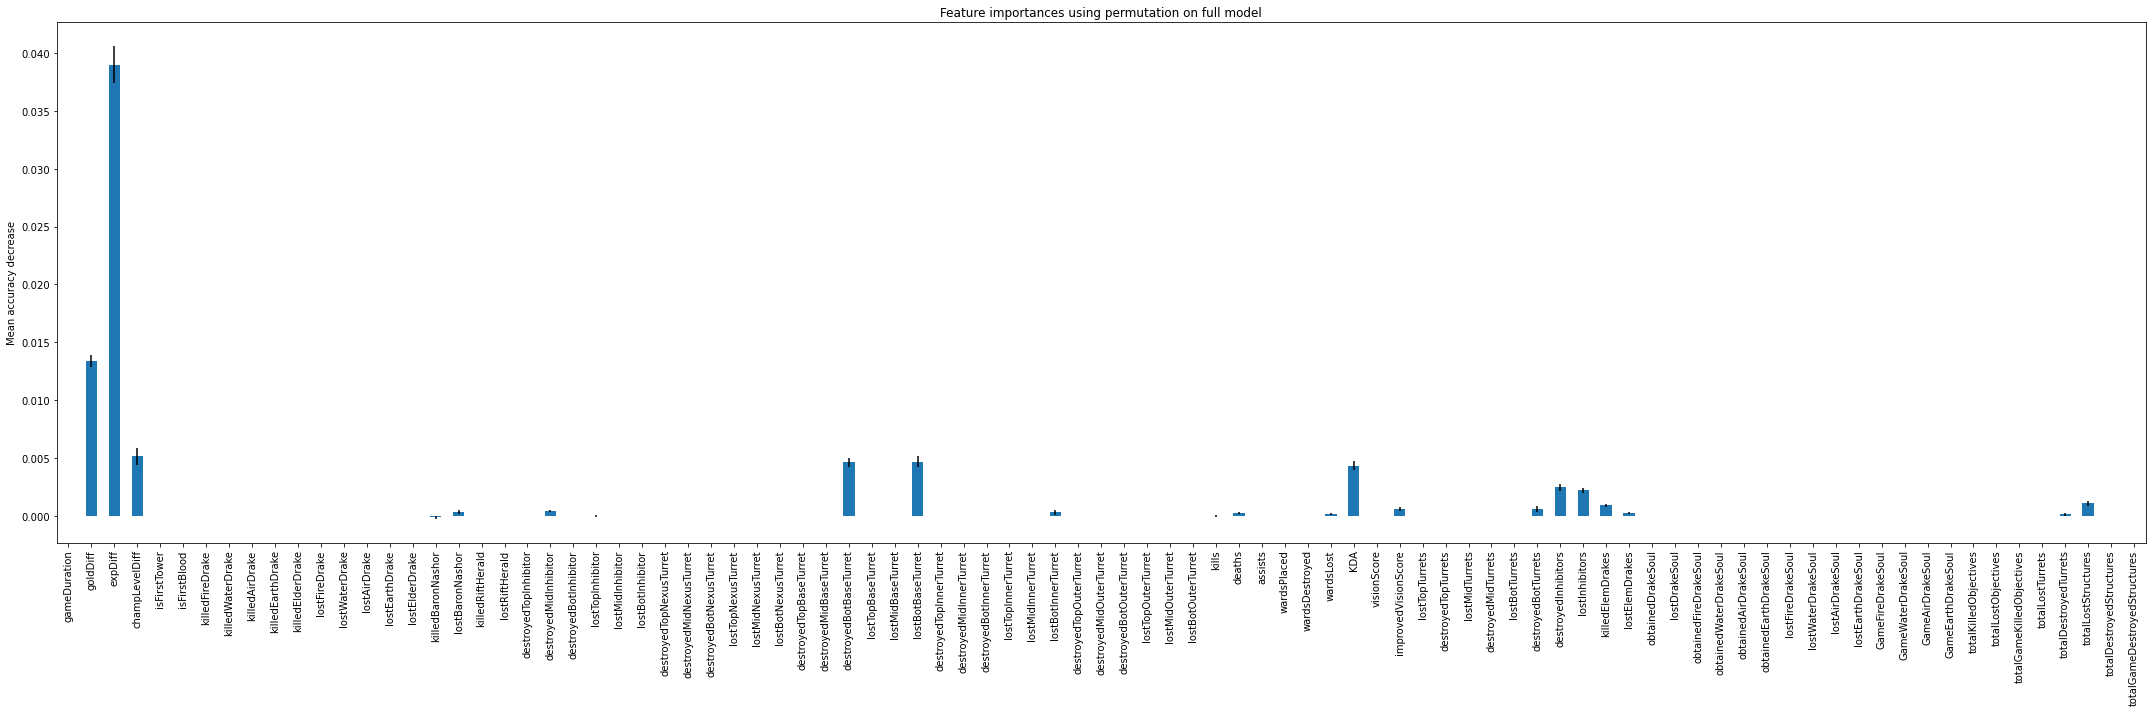

In [20]:
featureImportance(X_train,Y_train,
                  models['AdaBoostClassifier'][0],
                  X_train.columns,
                  (30,10),
                 )

A nivell de la importancia dels atributs aquí ja està molt més diversificat que als anteriors. La més dominant ara es `expDiff`i després `goldDiff`

### Gradient Boosting Classifier

#### Classificació d'una sola feature

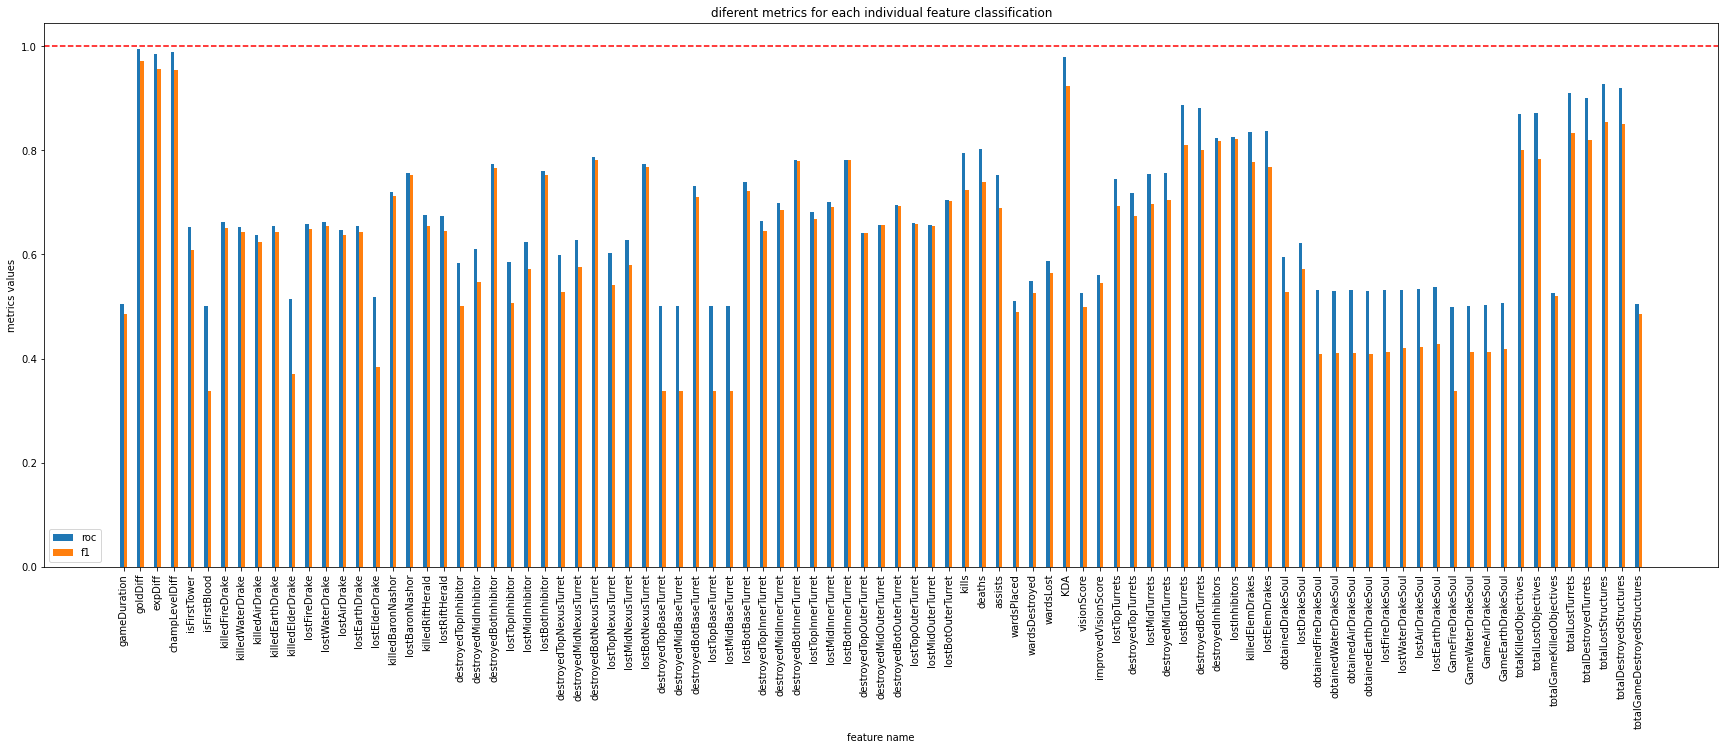

In [21]:
oneFeatureClassification(X_train,
                         Y_train,
                         X_test,
                         Y_test,
                         GradientBoostingClassifier(),
                        )

Els resultats son semblants al AdaBoost pero podem apreciar una petita millora en alguns dels atributs. Els millors segueixen sent els quatre que hem vist que també ho son als models anteriors.

#### Classificació amb tot el dataset

Model: GradientBoostingClassifier
Training time is:  6.32916259765625 s
Base sklearn score is:  0.9853501906482038
ROC score is:  0.9987429317094388
F1 score is: 0.9825407014553684
Accuracy score is: 0.9825406381697772
Precision score is: 0.9825414770254242


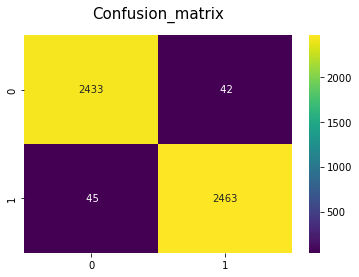

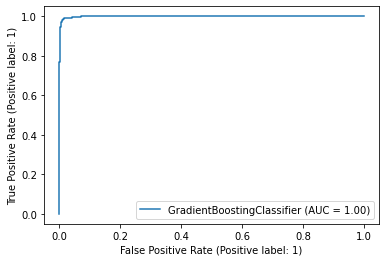

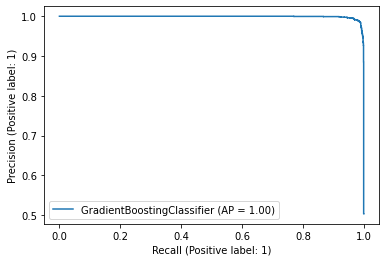

In [22]:
results=fullModelClassification(GradientBoostingClassifier(),X_train,Y_train,X_test,Y_test,True)
models[results[0]]=results[1]

A l'estil de l'AdaBoost obtenim molt bons resultats a canvi de trigar més que altres models.

#### Feature importance

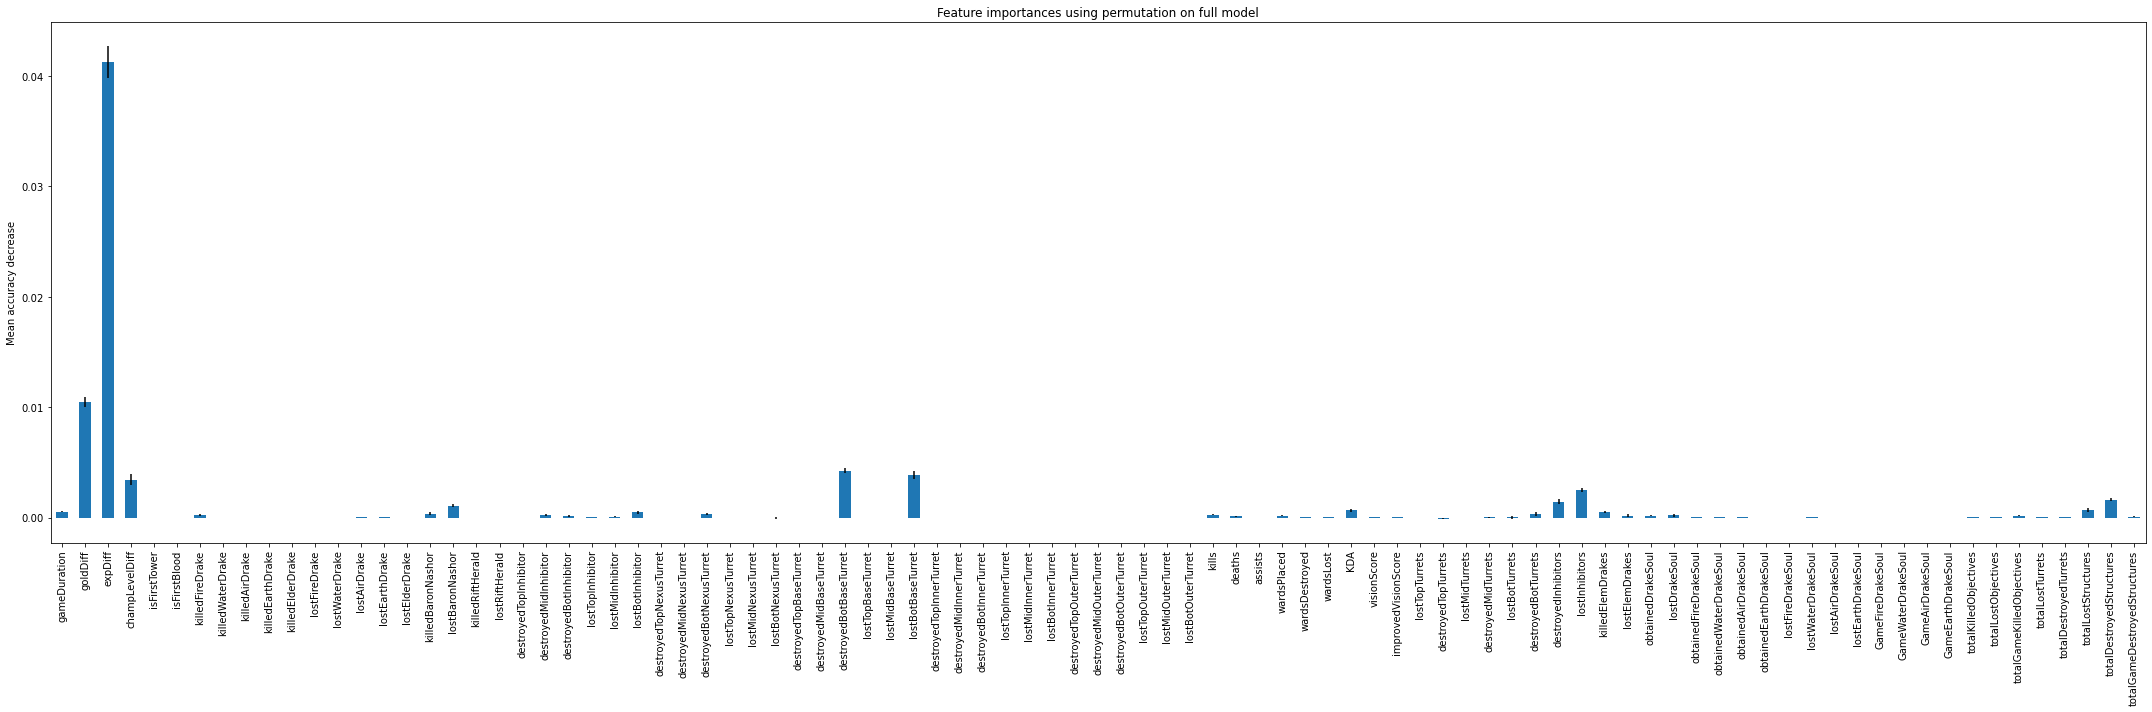

In [23]:
featureImportance(X_train,Y_train,
                  models['GradientBoostingClassifier'][0],
                  X_train.columns,
                  (30,10),
                 )

Tenim molta diversitat a l'importancia de les features. Si ens fixem la més important torna a ser `expDiff` igual que a l'AdaBoost

### Random Forest Classifier

#### Classificació d'una sola feature

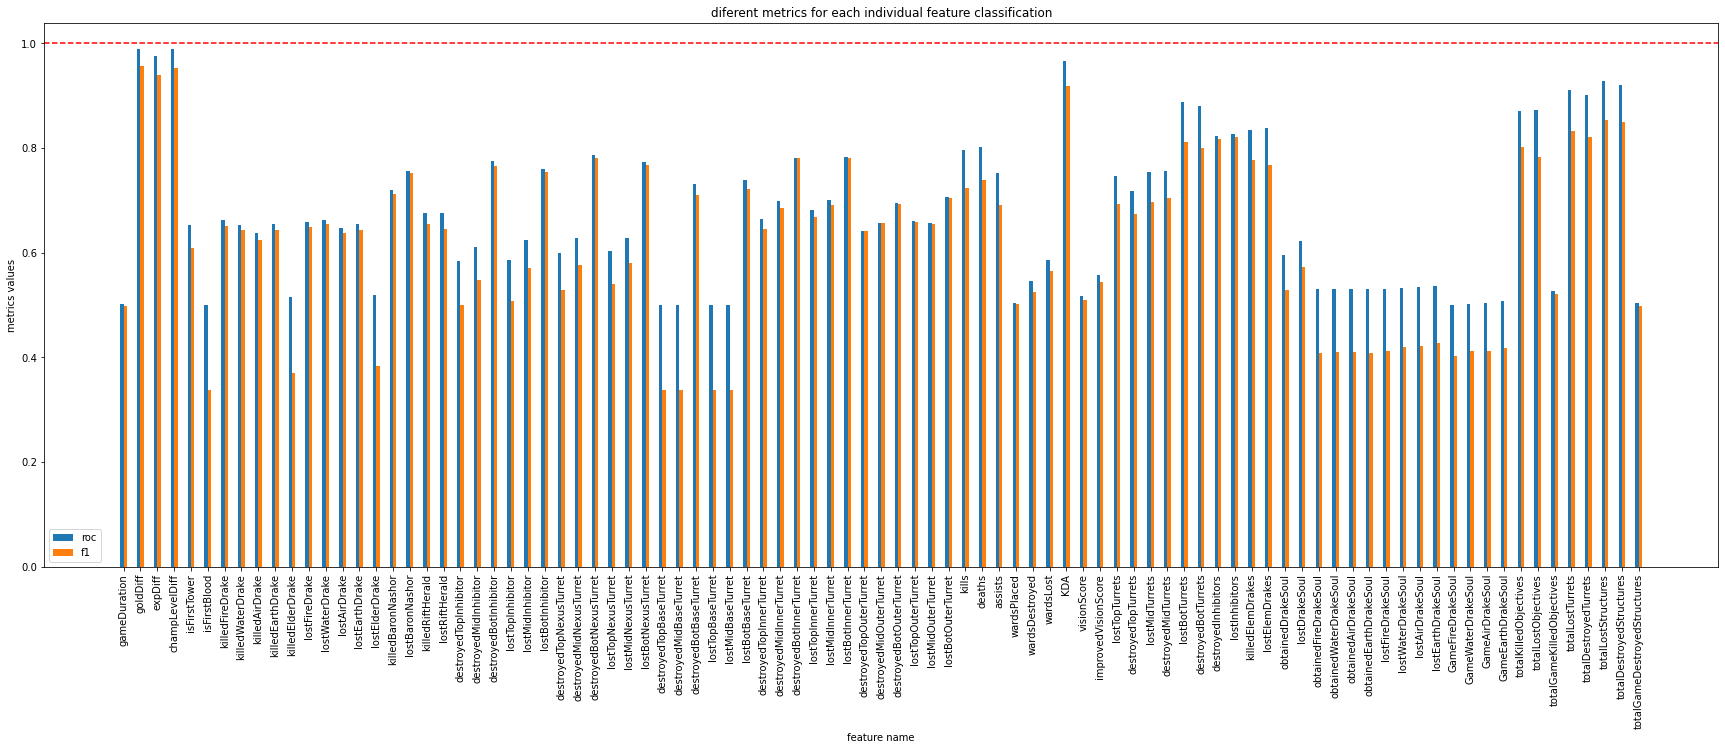

In [24]:
oneFeatureClassification(X_train,
                         Y_train,
                         X_test,
                         Y_test,
                         RandomForestClassifier(),
                        )

Obtenim uns resultats molt semblans als dos anteriors

#### Classificació amb tot el dataset

Model: RandomForestClassifier
Training time is:  1.7196507453918457 s
Base sklearn score is:  0.984748143688541
ROC score is:  0.9986270197992686
F1 score is: 0.9847482665404356
Accuracy score is: 0.984748143688541
Precision score is: 0.9847534658192264


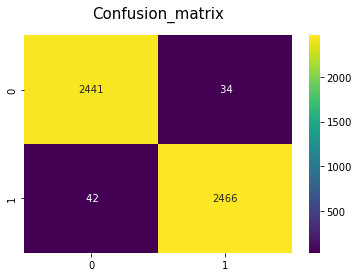

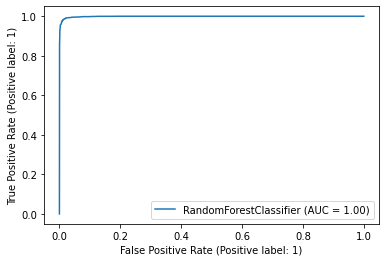

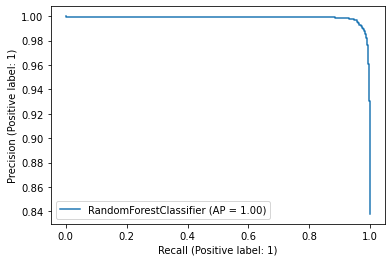

In [25]:
results=fullModelClassification(RandomForestClassifier(),X_train,Y_train,X_test,Y_test,True)
models[results[0]]=results[1]

Es més ràpid que els dos models anteriors i també ens dona molt bons resultats sense haver de fer cap inversió d'esforç extra.

#### Feature importance

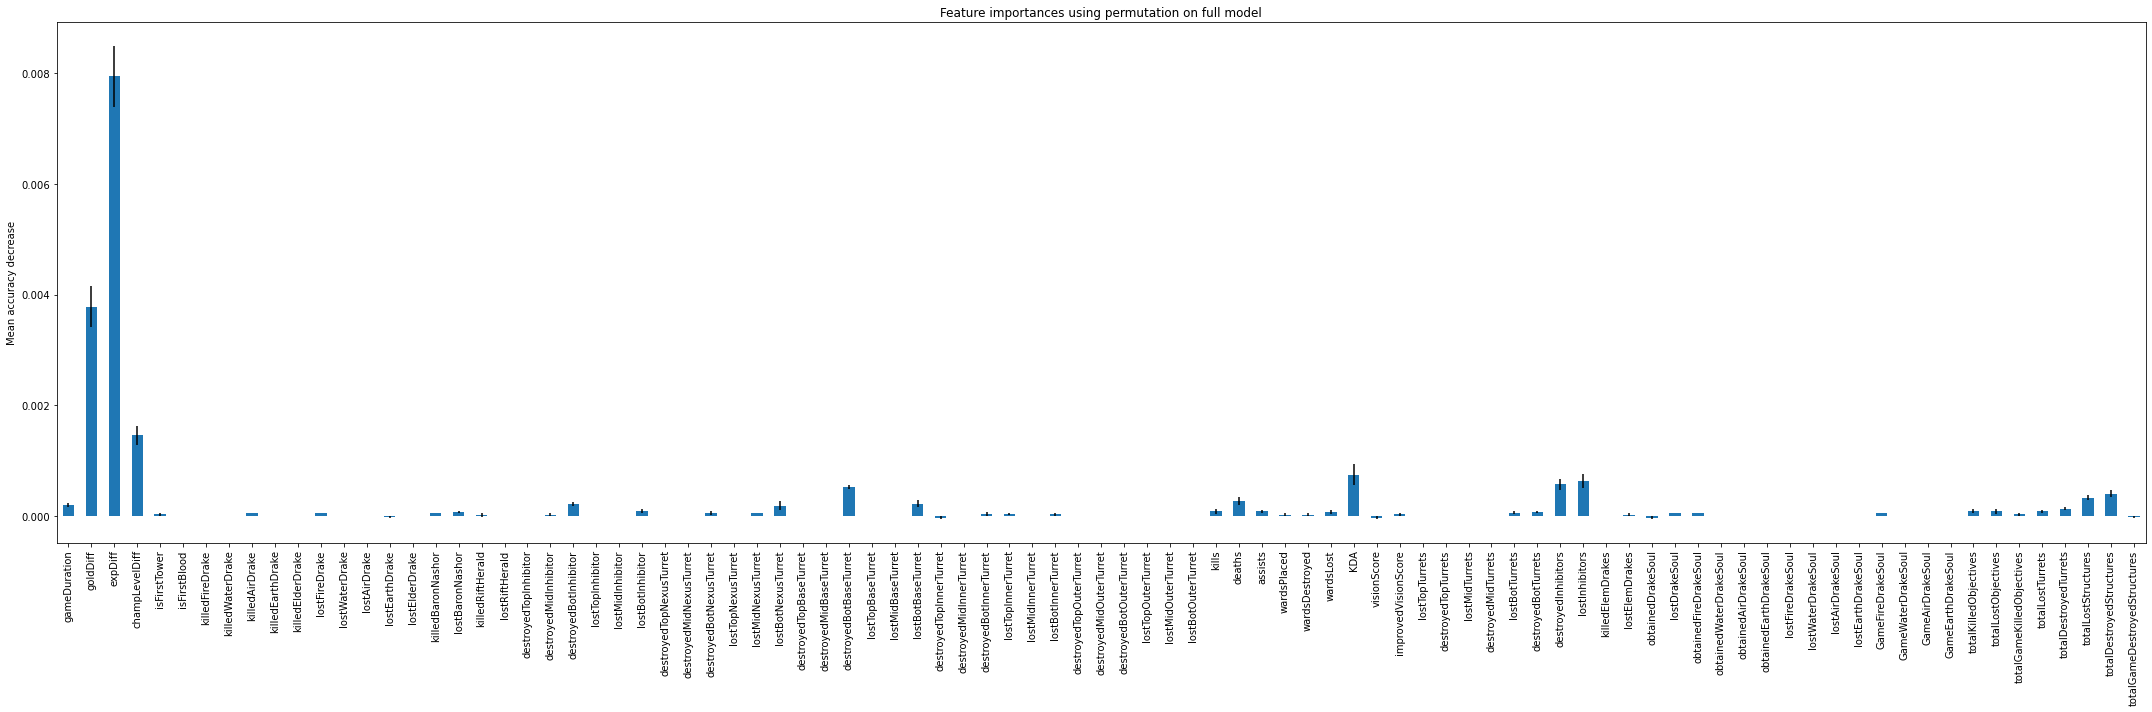

In [26]:
featureImportance(X_train,Y_train,
                  models['RandomForestClassifier'][0],
                  X_train.columns,
                  (30,10),
                 )

Veiem un altre cop que la feature dominant es `expDiff`i va seguida de `goldDiff`, hi ha també molta diversitat de features importants pero no tant com les dues anteriorment comentades.

#### MPLCassifier

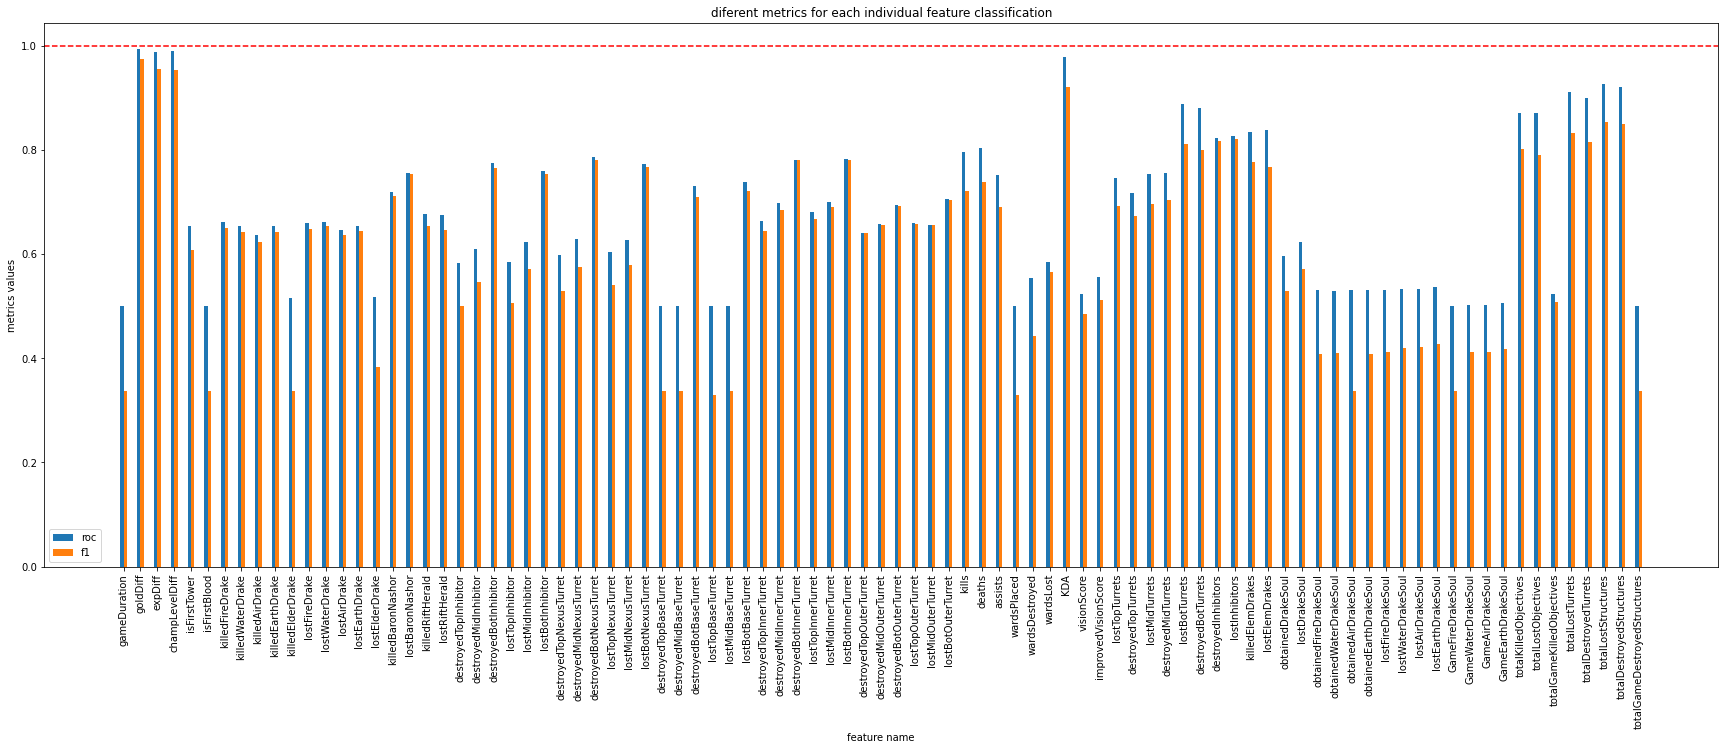

In [27]:
oneFeatureClassification(X_train,
                         Y_train,
                         X_test,
                         Y_test,
                         MLPClassifier(),
                        )

No hi ha massa a comentar respecte a la resta, es molt semblant als ultims models que hem vist, els millors segueixen sent els quatre de tots els models i la resta hi ha alguns amb resultats bons o decents i alguns que donen molt mals resultats.

#### Classificació amb tot el dataset

Model: MLPClassifier
Training time is:  1.3876006603240967 s
Base sklearn score is:  0.9741119807344973
ROC score is:  0.9798741804004962
F1 score is: 0.9578565295201894
Accuracy score is: 0.9578567128236002
Precision score is: 0.9579563416754873


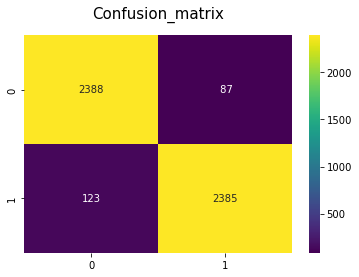

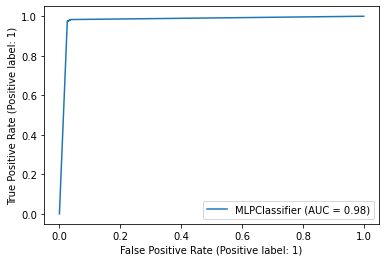

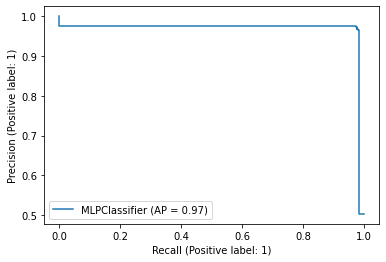

In [28]:
results=fullModelClassification(MLPClassifier(),X_train,Y_train,X_test,Y_test,True)
models[results[0]]=results[1]

Tenim un temps bastant correcte, però les mètriques son una mica més baixes que en alguns models anteriors, però son també molt bones i donen una molt bona classificació.

#### Feature importance

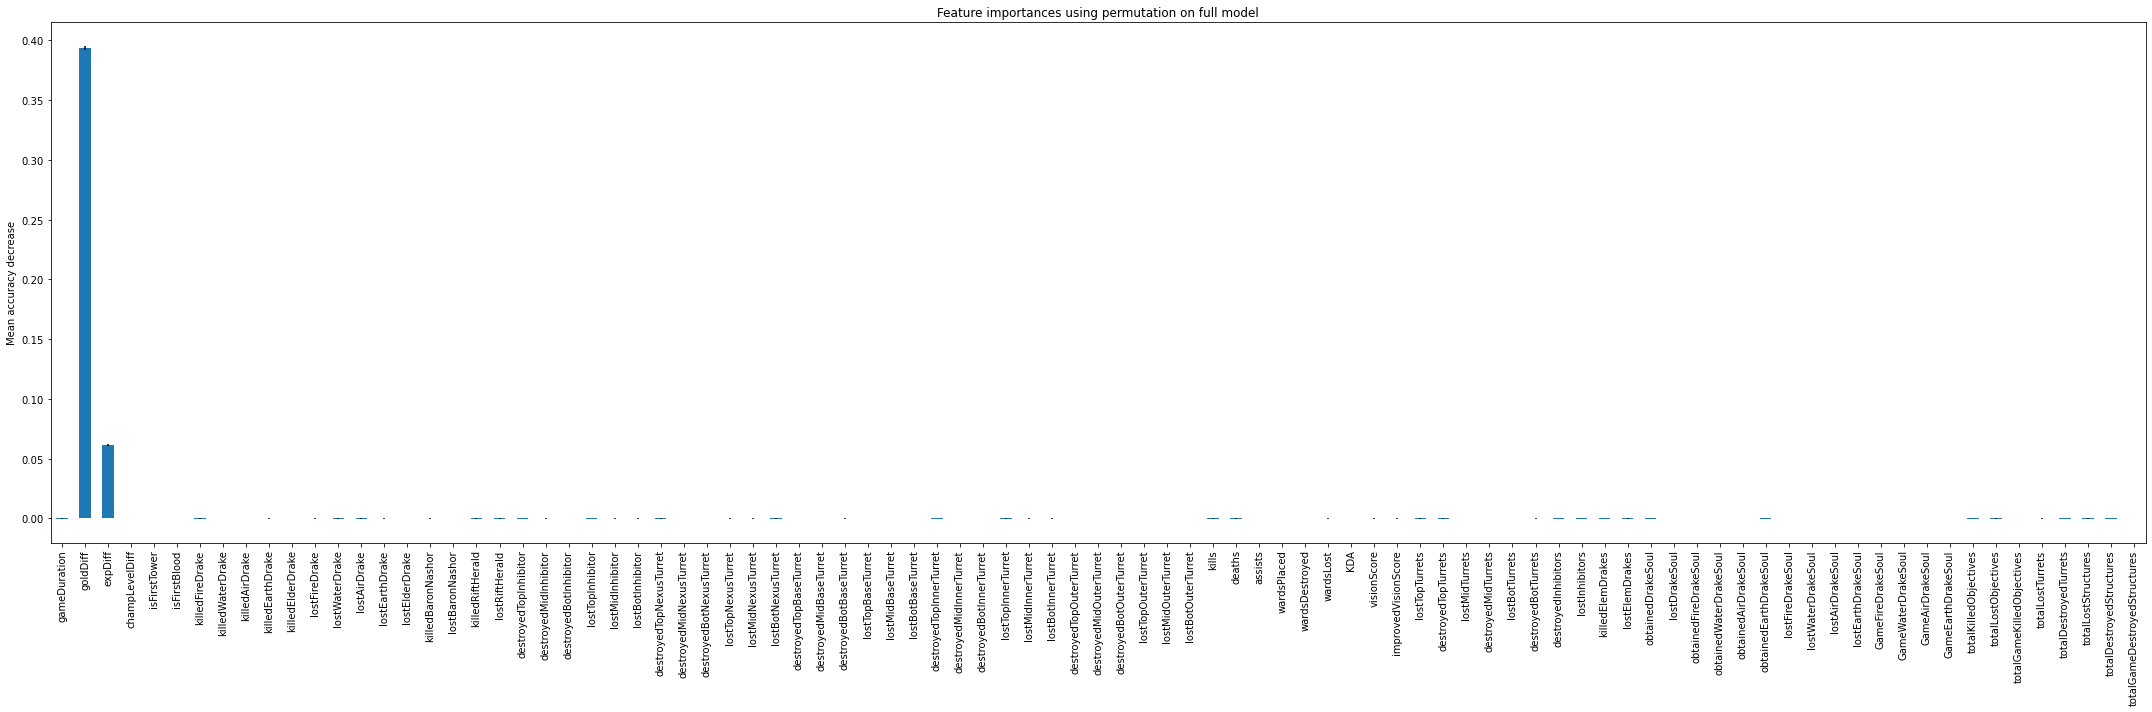

In [29]:
featureImportance(X_train,Y_train,
                  models['MLPClassifier'][0],
                  X_train.columns,
                  (30,10),
                 )

Observem que aquest model simplifica molt la feature importance, ara nomes es veuen dues molt per sobre de la resta. La més important es `goldDiff`i la segona `expDiff`

## Conclusions

In [30]:
results=pd.DataFrame({
    "Score":[models[i][2]['score'] for i in models.keys() ],
    "ROC AUC":[models[i][2]['ROC'] for i in models.keys() ],
    "F1":[models[i][2]['F1'] for i in models.keys() ],
    "Accuracy":[models[i][2]['Accuracy'] for i in models.keys() ],
    "Precision":[models[i][2]['Precision'] for i in models.keys() ],
    "Time":[models[i][1] for i in models.keys() ],
    })

In [31]:
results.index=list(models.keys())

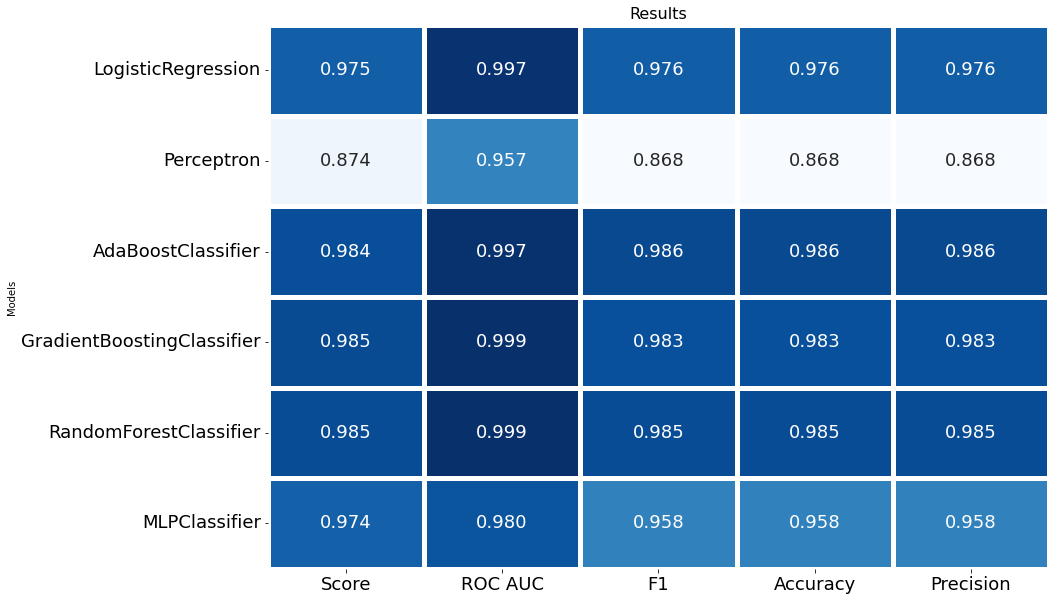

In [32]:
f,ax = plt.subplots(figsize=(14,10))

sns.heatmap(results.drop("Time",axis=1), annot=True,cmap = "Blues",fmt= '.3f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 18})

plt.xticks(size = 18)
plt.yticks(size = 18, rotation = 0)
plt.ylabel("Models")
plt.title("Results", size = 16)
plt.show()

Podem observar que a nivell de mètriques tots obtenen molt bons resultats, exceptuant el perceptró, tot i que els resultats tampoc son dolents. D'aquests models els quatre que donen el millor resultat son la logistica, el ada boost, el gradient boost i el random forest amb uns resultats tots molt semblants, tot i que aquests ultims son una mica superiors a la lógistica. Tot i així la logística com es un model molt simple te aquest punt al seu favor com veurem a continuació al mirar els temps d'execució tots junts.

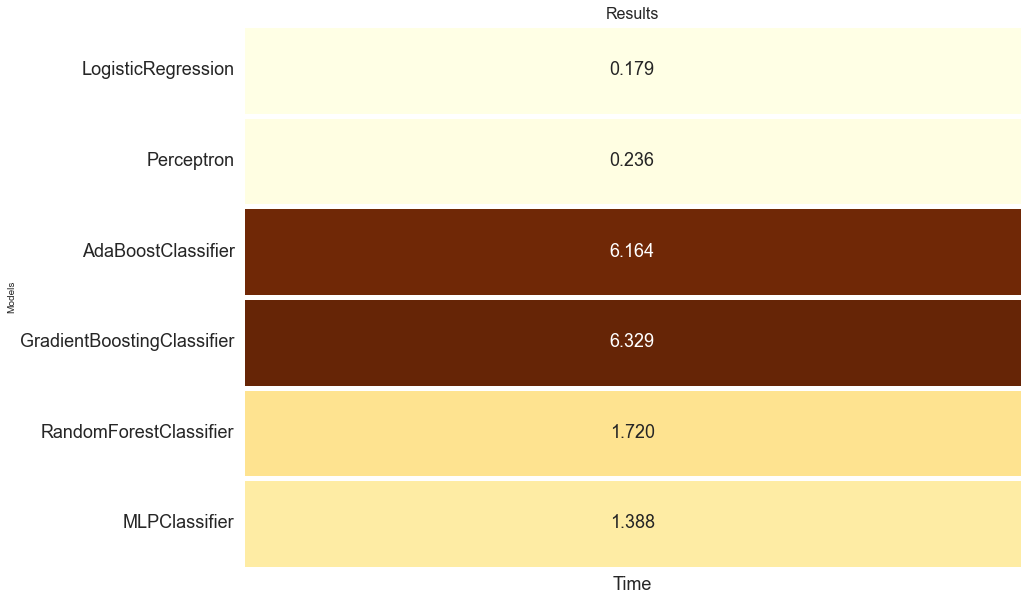

In [33]:
sns.set_style("darkgrid")
f,ax = plt.subplots(figsize=(14,10))

sns.heatmap(np.array(results["Time"]).reshape(-1,1), annot=True,cmap = "YlOrBr",fmt= '.3f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 18},
            yticklabels=list(results.index),
            xticklabels=["Time"])

plt.xticks(size = 18)
plt.yticks(size = 18, rotation = 0)
plt.ylabel("Models")
plt.title("Results", size = 16)
plt.show()

Així doncs mirant els temps podem concloure que els millors son la regressió logística, que es uns quaranta cops més rapida que l'ada boost i el gradient boost, i el random forest que es uns tres cops més rapid que l'ada i el gradient boost. Si volem el model més rapid en proporció als resultats sense dubte la millor es la logistica, tot i així el random forest ens pot ser util si se'ns introduissin noves dades més complexes de predir que les que tenim al nostre dataset.

També es important veure com per a tots els models els dos atributs que sempre son mes importants son `goldDiff` i `expDiff` i per tant son aquests aspectes els que hauriem d'intentar maximitar quan juguem per així guanyar.

S'ha de comentar que aquest dataframe contenia només el moment final de cada partida i que a causa dels bons resultats no ha fet falta afegir nous atributs que ens donesin informació de diferents moments de la partida o variacions i canvis en aquests.